## Cassava Leaf Disease Classification:

# Best Keras CNN

![Cassava](https://cdn.hauschka.com/images/system/plant_library/hauschka/manihot-esculenta-crantz-gross.jpg)

### The final part of this [Cassava Leaf Disease: Keras CNN baseline](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-baseline) and this [Cassava Leaf Disease: Keras CNN prediction](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-prediction) notebooks.

### Some models and weights stored in this dataset: [Cassava Leaf Disease Models](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-models)

#### Here you'll find:
* examples of ImageDataGenerator work;
* my best experiments with EfficientNet CNNs;
* visualizations of CNN intermediate activations;
* something else interesting in the future.

#### Ideas for future improvements:
* try various image sizes;
* try various batch sizes;
* experiments with learning rate;
* experiments with data augmentation;
* other.

#### I am grateful to François Cholet for the book "Deep Learning with Python", wherefrom I borrowed some useful techniques.

### History of changes:
#### Ver.4: changed TARGET_SIZE; removed unnecessary parameters of ImageDataGenerator

## Loading packages

In [ ]:
from google.colab import auth
auth.authenticate_user()


# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

In [ ]:
cd gdrive/MyDrive/cassava

/content/gdrive/MyDrive/cassava


In [ ]:
# import tensorflow as tf
# from tensorflow.keras import datasets, layers, models

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

## Work directory

In [ ]:
WORK_DIR = './input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['sample_submission.csv',
 'train.csv',
 'label_num_to_disease_map.json',
 'test_tfrecords',
 'train_images',
 'train_tfrecords',
 'test_images']

# First look at the data

In [ ]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [ ]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [ ]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

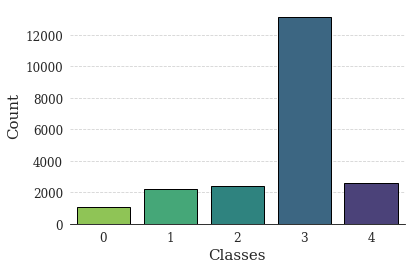

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (6, 4))

for i in ['top', 'right', 'left']:
    ax.spines[i].set_visible(False)
ax.spines['bottom'].set_color('black')

sns.countplot(train_labels.label, edgecolor = 'black',
              palette = reversed(sns.color_palette("viridis", 5)))
plt.xlabel('Classes', fontfamily = 'serif', size = 15)
plt.ylabel('Count', fontfamily = 'serif', size = 15)
plt.xticks(fontfamily = 'serif', size = 12)
plt.yticks(fontfamily = 'serif', size = 12)
ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
plt.show()

## Some photos of "0": "Cassava Bacterial Blight (CBB)"

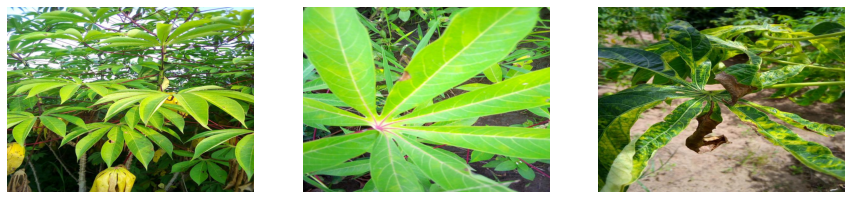

In [ ]:
sample = train_labels[train_labels.label == 0].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

## Some photos of "1": "Cassava Brown Streak Disease (CBSD)"

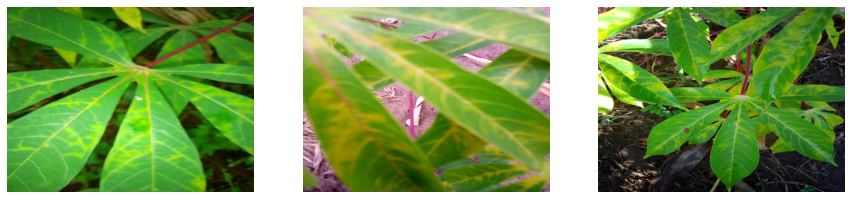

In [ ]:
sample = train_labels[train_labels.label == 1].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

## Some photos of "2": "Cassava Green Mottle (CGM)"

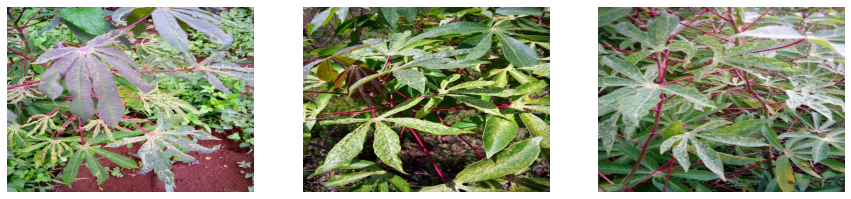

In [ ]:
sample = train_labels[train_labels.label == 2].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

## Some photos of "3": "Cassava Mosaic Disease (CMD)"

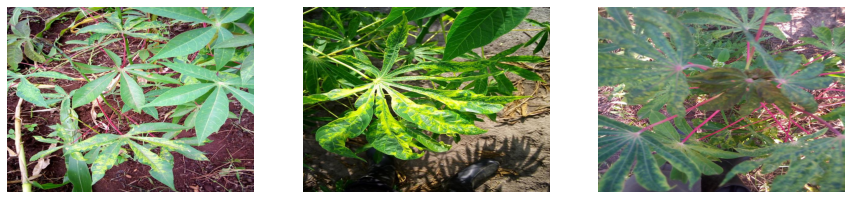

In [ ]:
sample = train_labels[train_labels.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

## Some photos of "4": "Healthy"

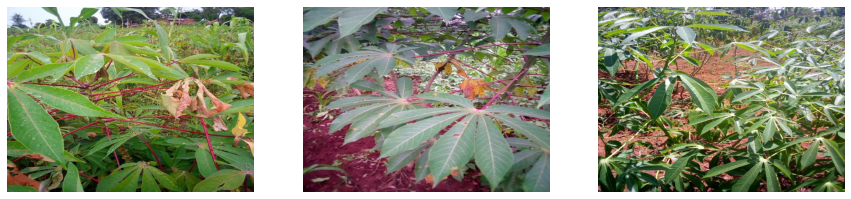

In [ ]:
sample = train_labels[train_labels.label == 4].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

# Preparation for modeling

In [ ]:
# Main parameters
BATCH_SIZE = 10
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 6
TARGET_SIZE = 512

### ImageDataGenerator

In [ ]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


There is a wide space for experimentation here. The cells below show how the ImageDataGenerator works.

### Random photo before augmentation

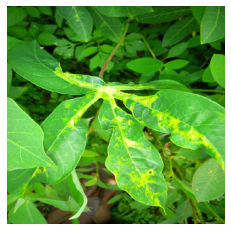

In [ ]:
img_path = os.path.join(WORK_DIR, "train_images", train_labels.image_id[20])
img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

### This photo after augmentation

Found 1 validated image filenames belonging to 1 classes.


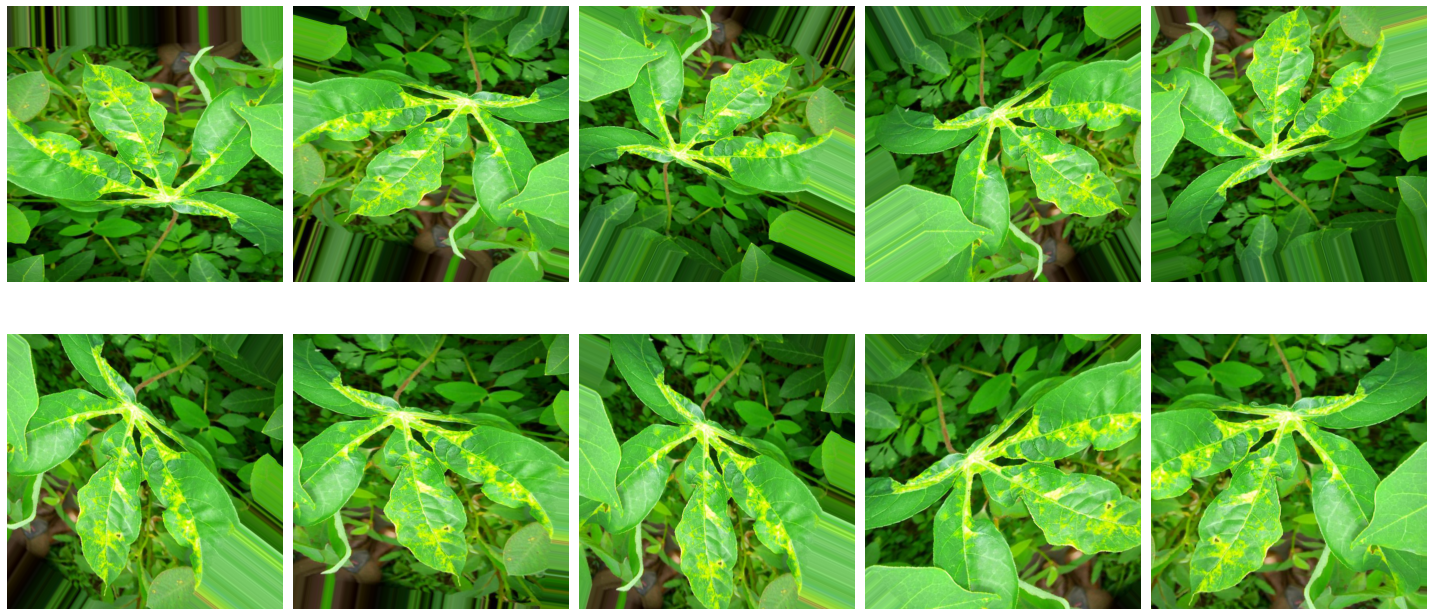

In [ ]:
generator = train_datagen.flow_from_dataframe(train_labels.iloc[20:21],
                         directory = os.path.join(WORK_DIR, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Modeling

At first, we'll load the basic EfficientNetB0 CNN with "imagenet" weights. I created this model before and store it in my dataset created especially for this competition: [Cassava Leaf Disease Models](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-models).

In [ ]:
# Code for basic EfficientNetB0 CNN

# def create_model():
#     conv_base = EfficientNetB0(include_top = False, weights = 'imagenet',
#                                input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
#     model = conv_base.output
#     model = layers.GlobalAveragePooling2D()(model)
#     model = layers.Dense(5, activation = "softmax")(model)
#     model = models.Model(conv_base.input, model)

#     model.compile(optimizer = Adam(lr = 0.001),
#                   loss = "sparse_categorical_crossentropy",
#                   metrics = ["acc"])
#     return model

# model = create_model()
# model.summary()

In [ ]:
# model.save('./basic_EfNetB0_imagenet_512.h5')

### Creating the CNN

In [ ]:
def create_model():
    conv_base = EfficientNetB1(include_top = False, weights = None,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
model = create_model()

In [ ]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

Our EfficientNet CNN has 341 layers


### Loading weights

In [ ]:

!ls

EffNetB0_512_8_best_weights.h5	EffNetB0_512_8.h5  input


In [ ]:
model.load_weights('EffNetB0_512_8_best_weights.h5')

### Training

In [ ]:
model_save = ModelCheckpoint('./EffNetB0_512_8_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/6
1711/1711 [==============================] - 1546s 903ms/step - loss: 0.4342 - acc: 0.8482 - val_loss: 0.4648 - val_acc: 0.8380

Epoch 00001: val_loss improved from inf to 0.46477, saving model to ./EffNetB0_512_8_best_weights.h5
Epoch 2/6
1711/1711 [==============================] - 1546s 903ms/step - loss: 0.4342 - acc: 0.8497 - val_loss: 0.4293 - val_acc: 0.8544

Epoch 00002: val_loss improved from 0.46477 to 0.42926, saving model to ./EffNetB0_512_8_best_weights.h5
Epoch 3/6
1711/1711 [==============================] - 1538s 898ms/step - loss: 0.4258 - acc: 0.8520 - val_loss: 0.4385 - val_acc: 0.8474

Epoch 00003: val_loss did not improve from 0.42926
Epoch 4/6
1711/1711 [==============================] - 1540s 899ms/step - loss: 0.4239 - acc: 0.8546 - val_loss: 0.4276 - val_acc: 0.8542

Epoch 00004: val_loss improved from 0.42926 to 0.42762, saving model to ./EffNetB0_512_8_best_weights.h5
Epoch 5/6
1711/1711 [==============================] - 1541s 900ms/step - loss: 0.

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

NameError: ignored

In [ ]:
model.save('./EffNetB0_512_8.h5')

# Visualization of CNN intermediate activations

In [ ]:
def activation_layer_vis(img, activation_layer = 0, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    rows = int(activations[activation_layer].shape[3] / 3)
    cols = int(activations[activation_layer].shape[3] / rows)
    fig, axes = plt.subplots(rows, cols, figsize = (15, 15 * cols))
    axes = axes.flatten()
    
    for i, ax in zip(range(activations[activation_layer].shape[3]), axes):
        ax.matshow(activations[activation_layer][0, :, :, i], cmap = 'viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Visualization of the first layer

In [ ]:
activation_layer_vis(img_tensor, 0)

NameError: ignored

In [ ]:
def all_activations_vis(img, layers = 10):
    layer_outputs = [layer.output for layer in model.layers[:layers]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img)
    
    layer_names = []
    for layer in model.layers[:layers]: 
        layer_names.append(layer.name) 

    images_per_row = 3
    for layer_name, layer_activation in zip(layer_names, activations): 
        n_features = layer_activation.shape[-1] 

        size = layer_activation.shape[1] 

        n_cols = n_features // images_per_row 
        display_grid = np.zeros((size * n_cols, images_per_row * size)) 

        for col in range(n_cols): 
            for row in range(images_per_row): 
                channel_image = layer_activation[0, :, :, col * images_per_row + row] 
                channel_image -= channel_image.mean() 
                channel_image /= channel_image.std() 
                channel_image *= 64 
                channel_image += 128 
                channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
                display_grid[col * size : (col + 1) * size, 
                             row * size : (row + 1) * size] = channel_image 
        scale = 1. / size 
        plt.figure(figsize=(scale * 5 * display_grid.shape[1], 
                            scale * 5 * display_grid.shape[0])) 
        plt.title(layer_name) 
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

### Visualization of the first 5 layers

In [ ]:
all_activations_vis(img_tensor, 5)

NameError: ignored

Visualization of intermediate activations gives a rough step-by-step understanding of how CNN works.

# Prediction

In [ ]:
ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss

image_id  label
0  2216849948.jpg      4

In [ ]:
preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

image_id  label
0  2216849948.jpg      4

In [ ]:
ss.to_csv('submission.csv', index = False)

### See also [Cassava Leaf Disease: Keras CNN baseline](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-baseline)

## WORK IN PROGRESS...